In [1]:
from glob import glob
from itertools import combinations, permutations, product
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
from scipy.ndimage.morphology import binary_fill_holes
from scipy.stats import norm
from skimage.color import gray2rgb
from skimage.draw import line
from skimage.graph import route_through_array
from skimage.io import ImageCollection, imread, imsave
from skimage.util import img_as_float, img_as_ubyte
from skimage.filters import threshold_otsu, threshold_yen, threshold_li, threshold_isodata
from skimage.measure import regionprops, label, compare_ssim
from skimage.morphology import remove_small_objects, skeletonize, skeletonize_3d
from skimage.segmentation import clear_border

from supmat_support import *

import desiqueira2018 as ds

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import os
import statistics as stats

plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
plt.rcParams['legend.fontsize'] = 1.5*plt.rcParams['font.size']
plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
%matplotlib inline

## Obtaining the image collection

* First, we use `ImageCollection()` to read all images in the folder `orig_figures`. After that, we print the number of images in this dataset.

In [2]:
def imread_convert(image):
    """Support function for ImageCollection. Converts the input image to
    gray.
    """

    return imread(image, as_grey=True)

imgset_mica = ImageCollection(load_pattern='orig_figures/*mica*.tif', load_func=imread_convert)
imgset_apatite = ImageCollection(load_pattern='orig_figures/*apatite*.tif', load_func=imread_convert)

print('Number of images on dataset: ', len(imgset_mica) + len(imgset_apatite))

Number of images on dataset:  79


## Binarizing images

* Here we binarize all images using different algorithms: Otsu, Yen, Li, ISODATA, triangle, MLSS.

* We also perform some cleaning actions:
    * `remove_small_objects()`, in its default settings, removes objects with an area smaller than 64 px.
    * `binary_fill_holes()` fills holes contained in objects.
    * `clear_rd_border()` removes objects touching the lower and right borders. These objects could not be identified with precision.

* After that, we present the results of these actions on the first images from the set.

In [3]:
def binarize_imageset(image_set):
    
    imgbin_otsu, imgbin_yen, imgbin_li, imgbin_iso, imgbin_tri, imgbin_mlss = [[] for _ in range(6)]

    for idx, img in enumerate(image_set):
        # Filtering
        img = ndimage.median_filter(img, size=(7, 7))
        # Otsu
        imgbin_otsu.append(binarize_imageset_aux(img < threshold_otsu(img)))
        # Yen
        imgbin_yen.append(binarize_imageset_aux(img < threshold_yen(img)))
        # Li
        imgbin_li.append(binarize_imageset_aux(img < threshold_li(img)))
        # ISODATA
        imgbin_iso.append(binarize_imageset_aux(img < threshold_isodata(img)))
        # MLSS
        aux = pd.read_csv('auto_count/mlss/imgbin_mlss' + str(idx+1) + '.csv')
        imgbin_mlss.append(binarize_imageset_aux(np.asarray(aux, dtype='bool')))

    return imgbin_otsu, imgbin_yen, imgbin_li, imgbin_iso, imgbin_mlss


def binarize_imageset_aux(image):
    
    return ds.clear_rd_border(remove_small_objects(binary_fill_holes(image)))

* Binarizing images.

In [4]:
binotsu_mica, binyen_mica, binli_mica, biniso_mica, binmlss_mica = binarize_imageset(imgset_mica)
binotsu_apatite, binyen_apatite, binli_apatite, biniso_apatite, binmlss_apatite = binarize_imageset(imgset_apatite)

### Samples

In [4]:
testimg_apatite = imread('orig_figures/dur_grain1apatite01.tif', as_grey=True)
testimg_mica = imread('orig_figures/dur_grain1mica01.tif', as_grey=True)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 9), nrows=1, ncols=3)

# Otsu
ax[0].imshow(binotsu_mica[0], cmap='gray')
ax[0].set_xlabel('Otsu')

# Yen
ax[1].imshow(binyen_mica[0], cmap='gray')
ax[1].set_xlabel('Yen')

# Li
ax[2].imshow(binli_mica[0], cmap='gray')
ax[2].set_xlabel('Li')

fig, ax = plt.subplots(figsize=(18, 9), nrows=1, ncols=2)

# ISODATA
ax[0].imshow(biniso_mica[0], cmap='gray')
ax[0].set_xlabel('ISODATA')

# MLSS
ax[1].imshow(binmlss_mica[0], cmap='gray')
ax[1].set_xlabel('MLSS')

In [ ]:
fig, ax = plt.subplots(figsize=(18, 9), nrows=1, ncols=3)

# Otsu
ax[0].imshow(binotsu_apatite[0], cmap='gray')
ax[0].set_xlabel('Otsu')

# Yen
ax[1].imshow(binyen_apatite[0], cmap='gray')
ax[1].set_xlabel('Yen')

# Li
ax[2].imshow(binli_apatite[0], cmap='gray')
ax[2].set_xlabel('Li')

fig, ax = plt.subplots(figsize=(18, 9), nrows=1, ncols=2)

# ISODATA
ax[0].imshow(biniso_apatite[0], cmap='gray')
ax[0].set_xlabel('ISODATA')

# MLSS
ax[1].imshow(binmlss_apatite[0], cmap='gray')
ax[1].set_xlabel('MLSS')

## Pre-processing images

* Separating regions and skeletonizing.

In [ ]:
regotsu_mica = ds.regions_and_skel(binotsu_mica)
regyen_mica = ds.regions_and_skel(binyen_mica)
regli_mica = ds.regions_and_skel(binli_mica)
regiso_mica = ds.regions_and_skel(biniso_mica)
regmlss_mica = ds.regions_and_skel(binmlss_mica)

In [ ]:
regotsu_apatite = ds.regions_and_skel(binotsu_apatite)
regyen_apatite = ds.regions_and_skel(binyen_apatite)
regli_apatite = ds.regions_and_skel(binli_apatite)
regiso_apatite = ds.regions_and_skel(biniso_apatite)
regmlss_apatite = ds.regions_and_skel(binmlss_apatite)

## Automatic counting

* Functions for classifying and counting tracks.

* Please uncomment (remove the `#` in) the lines that start with `autocount_` below to generate the results. If you do not want to calculate them, they are already stored in the folder `auto_count`.

### Otsu

In [ ]:
# counting tracks in mica.
ds.count_and_save(regotsu_mica,
                  filename='auto_count/autootsu_mica.csv',
                  show_exectime=False)
# counting tracks in apatite.
ds.count_and_save(regotsu_apatite,
                  filename='auto_count/autootsu_apatite.csv',
                  show_exectime=False)

### Yen

In [ ]:
# counting tracks in mica.
ds.count_and_save(regyen_mica,
                  filename='auto_count/autoyen_mica.csv',
                  show_exectime=False)

# counting tracks in apatite.
ds.count_and_save(regyen_apatite,
                  filename='auto_count/autoyen_apatite.csv',
                  show_exectime=False)

### Li

In [ ]:
# counting tracks in mica.
ds.count_and_save(regli_mica,
                  filename='auto_count/autoli_mica.csv',
                  show_exectime=False)

# counting tracks in apatite.
ds.count_and_save(regli_apatite,
                  filename='auto_count/autoli_apatite.csv',
                  show_exectime=False)

### ISODATA

In [ ]:
# counting tracks in mica.
ds.count_and_save(regiso_mica,
                  filename='auto_count/autoiso_mica.csv',
                  show_exectime=False)

# counting tracks in apatite.
ds.count_and_save(regiso_apatite,
                  filename='auto_count/autoiso_apatite.csv',
                  show_exectime=False)

### MLSS

In [ ]:
# counting tracks in mica.
ds.count_and_save(regmlss_mica,
                  filename='auto_count/automlss_mica.csv',
                  show_exectime=False)

# counting tracks in apatite.
ds.count_and_save(regmlss_apatite,
                  filename='auto_count/automlss_apatite.csv',
                  show_exectime=False)

* Reading automatic counting.

In [60]:
autootsu_mica = np.loadtxt('auto_count/autootsu_mica.csv', delimiter=',')
autoyen_mica = np.loadtxt('auto_count/autoyen_mica.csv', delimiter=',')
autoli_mica = np.loadtxt('auto_count/autoli_mica.csv', delimiter=',')
autoiso_mica = np.loadtxt('auto_count/autoiso_mica.csv', delimiter=',')
automlss_mica = np.loadtxt('auto_count/automlss_mica.csv', delimiter=',')

In [61]:
autootsu_apatite = np.loadtxt('auto_count/autootsu_apatite.csv', delimiter=',')
autoyen_apatite = np.loadtxt('auto_count/autoyen_apatite.csv', delimiter=',')
autoli_apatite = np.loadtxt('auto_count/autoli_apatite.csv', delimiter=',')
autoiso_apatite = np.loadtxt('auto_count/autoiso_apatite.csv', delimiter=',')
automlss_apatite = np.loadtxt('auto_count/automlss_apatite.csv', delimiter=',')

## Manual counting

* Reading manual counting.

In [68]:
manual_mica = ds.manual_counting(mineral='mica')
manual_apatite = ds.manual_counting(mineral='apatite')

In [ ]:
def ratio_manauto(manual, auto):
    """
    """

    ratio = np.asarray(auto) / np.asarray(man)

    print('\n* Manual mean: ', str(manual.mean()), ' +/- ', str(manual.std()),
          '\n* Auto mean: ', str(auto.mean()), ' +/- ', str(auto.std()),
          '\n* Ratio mean: ', str(ratio.mean()), ' +/- ', str(ratio.std()))

    return None


In [ ]:
manual_mica / autootsu_mica

In [ ]:
print('* Otsu:')
ratio_manauto(np.asarray(manual_mica), np.asarray(autootsu_mica))
ratio_manauto(np.asarray(manual_apatite), np.asarray(autootsu_apatite))

In [ ]:
np.mean(automlss_mica)/np.mean(automlss_apatite)

In [ ]:
print('* Yen:')
ratio_manauto(np.asarray(manual_mica), np.asarray(autoyen_mica))
ratio_manauto(np.asarray(manual_apatite), np.asarray(autoyen_apatite))

In [ ]:
print('* Li:')
ratio_manauto(np.asarray(manual_mica), np.asarray(autoli_mica))
ratio_manauto(np.asarray(manual_apatite), np.asarray(autoli_apatite))

In [ ]:
print('* ISODATA:')
ratio_manauto(np.asarray(manual_mica), np.asarray(autoiso_mica))
ratio_manauto(np.asarray(manual_apatite), np.asarray(autoiso_apatite))

In [ ]:
print('* MLSS:')
ratio_manauto(np.asarray(manual_mica), np.asarray(automlss_mica))
ratio_manauto(np.asarray(manual_apatite), np.asarray(automlss_apatite))

In [ ]:
def plot_tracks(image, trk_averages, trk_points):
    '''
    '''

    if trk_averages is None:
        print('No averages (possibly only one track).')
        return None

    image_rgb = gray2rgb(image)

    # preparing the plot window.
    fig, ax = plt.subplots(nrows=1, ncols=1)

    for trk_idx, trk_pt in enumerate(trk_points):

        # calculating route and distances.
        route, _ = route_through_array(~image, trk_pt[0], trk_pt[1])
        distances, _, _ = ds.track_parameters(trk_pt[0], trk_pt[1], route)

        # generating minimal distance line.
        rows, cols = line(trk_pt[0][0], trk_pt[0][1],
                          trk_pt[1][0], trk_pt[1][1])
        image_rgb[rows, cols] = [0, 255, 0]

        # plotting minimal distance and route.
        ax.imshow(image_rgb, cmap='gray')

        for rt_pt in route:
            ax.scatter(rt_pt[1], rt_pt[0], c='b')

        #plotting extreme points.
        for pt in trk_pt:
            ax.scatter(pt[1], pt[0], c='g')

    return None

In [ ]:
np.mean(autoiso_mica)/np.mean(autoiso_apatite)

## Calibration and conversion: from $px$ to $cm^2$

Text(0,0.5,'Length (mm)')

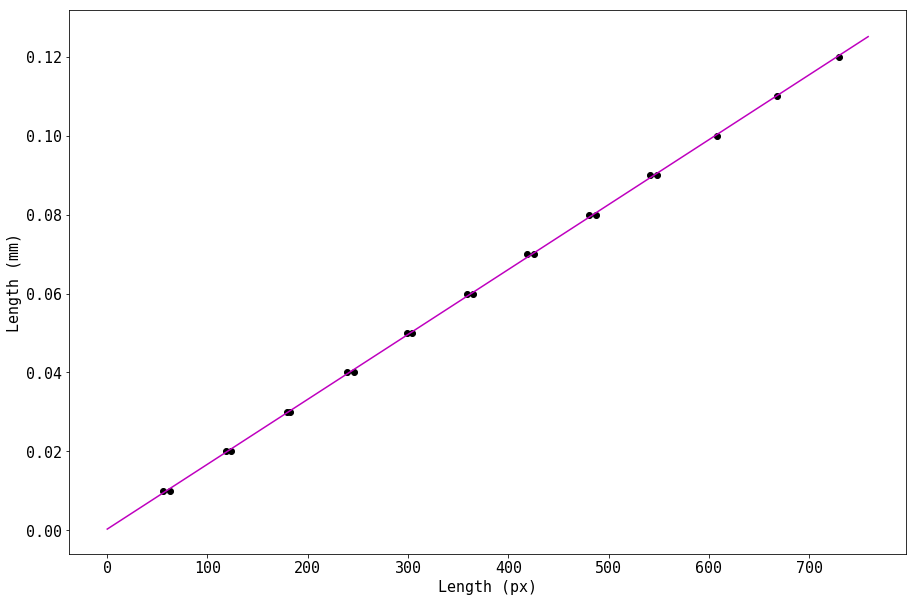

In [2]:
calib = pd.read_csv('calibration/calibration_curve.csv')
poly_coef = np.polyfit(x=calib['px'], y=calib['mm'], deg=1)

fit = np.arange(0, 760)
fit_mm = poly_coef[0] * fit + poly_coef[1]

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(x=calib['px'],
           y=calib['mm'],
           c='k')
ax.plot(fit, fit_mm, c='m')
ax.set_xlabel('Length (px)')
ax.set_ylabel('Length (mm)')

In [3]:
def px_to_mm(poly_coef, length=760):

    ang_coef, lin_coef = poly_coef
    mm = length*ang_coef + lin_coef

    return mm


def px_to_mm2(poly_coef, len_x=760, len_y=570):

    ang_coef, lin_coef = poly_coef
    mm2 = (len_x*ang_coef + lin_coef) * (len_y*ang_coef + lin_coef)

    return mm2


def px_to_cm2(len_x=760, len_y=570):
    return px_to_mm2(len_x, len_y) * 1e-8

In [8]:
px_to_mm(poly_coef, length=4.2) * 1e3

1.0082529810529153

In [114]:
def gqr_calc(mica, apatite):
    """
    """

    gqr = np.mean(mica/px_to_cm2()) / np.mean(apatite/px_to_cm2())

    return gqr


def track_stats(ext_detec, int_surf):
    """
    """

    # ed: external detector
    rho_ed = np.mean(ext_detec) / px_to_cm2()
    n_ed = np.sum(ext_detec)

    sigma_n_ed = np.sqrt(n_ed)
    relat_ed = 1/np.sqrt(n_ed)  # incerteza relativa
    sigma_rho_ed = relat_ed * rho_ed

    # is: internal surface
    rho_is = np.mean(int_surf) / px_to_cm2()
    n_is = np.sum(int_surf)

    sigma_n_is = np.sqrt(n_is)
    relat_is = 1/np.sqrt(n_is)  # incerteza relativa
    sigma_rho_is = relat_is * rho_is

    # GQR
    gqr = rho_ed / rho_is
    sigma_gqr = np.sqrt((relat_is ** 2) + (relat_ed ** 2)) * gqr

    stats = ((n_ed, sigma_n_ed), (n_is, sigma_n_is),
             (rho_ed * 1e-6, sigma_rho_ed * 1e-6),
             (rho_is * 1e-6, sigma_rho_is * 1e-6),
             (gqr, sigma_gqr))

    return stats

## Obtaining track stats for each counting.

In [62]:
track_stats(autootsu_mica, autootsu_apatite)

((2133.0, 46.184412955021955),
 (2279.0, 47.738873049120045),
 (369686.8878711773, 8004.581290904525),
 (645152.4371849076, 13514.19495221619),
 (0.5730225394238433, 0.017263222439557347))

In [63]:
track_stats(autoyen_mica, autoyen_apatite)

((2407.0, 49.06118628814432),
 (2484.0, 49.839743177508446),
 (417175.96770085505, 8503.1773437094),
 (703185.0170984248, 14108.921360087515),
 (0.5932662920240561, 0.016968156612859046))

In [64]:
track_stats(autoli_mica, autoli_apatite)

((2079.0, 45.59605246071199),
 (2150.0, 46.36809247747852),
 (360327.72615291964, 7902.607938777101),
 (608634.374702743, 13126.146498227487),
 (0.5920265780730898, 0.018210152050071))

In [65]:
track_stats(autoiso_mica, autoiso_apatite)

((2136.0, 46.216880033165374),
 (2282.0, 47.77028364998475),
 (370206.84129996935, 8010.208413772365),
 (646001.6944519347, 13523.086845898202),
 (0.5730741025595163, 0.017253022731376997))

In [66]:
track_stats(automlss_mica, automlss_apatite)

((5583.0, 74.71947537289057),
 (3346.0, 57.844619455918284),
 (967633.3309820829, 12950.21580589357),
 (947204.9384908734, 16374.987810451601),
 (1.0215670248972273, 0.02233425627526936))

In [69]:
track_stats(manual_mica, manual_apatite)

((2838, 53.27288240746881),
 (3114, 55.80322571321482),
 (491875.94363731885, 9233.139289800438),
 (881529.0431741123, 15797.09832016676),
 (0.5579804176005663, 0.0144805453864624))

## Counting time of each algorithm

In [70]:
count_time = pd.read_csv('counting_time.csv')

count_auto = [count_time[count_time['sample'] == 'mica']['otsu'],
              count_time[count_time['sample'] == 'mica']['yen'],
              count_time[count_time['sample'] == 'mica']['li'],
              count_time[count_time['sample'] == 'mica']['isodata'],
              count_time[count_time['sample'] == 'mica']['mlss']]

In [ ]:


    
for trk_idx, trk_pt in enumerate(trk_px):

    # calculating route and distances.
    route, _ = route_through_array(~img_aux, trk_pt[0], trk_pt[1])
    distances, _, _ = ds.track_parameters(trk_pt[0], trk_pt[1], route)

    # generating minimal distance line.
    rows, cols = line(trk_pt[0][0], trk_pt[0][1],
                      trk_pt[1][0], trk_pt[1][1])
    rgb_otsu[rows, cols] = [0, 255, 0]

    # plotting minimal distance and route.
    ax[1].imshow(rgb_otsu, cmap='gray')

    for rt_pt in route:
        ax[1].scatter(rt_pt[1], rt_pt[0], c='b')

    #plotting extreme points.
    for pt in trk_pt:
        ax[1].scatter(pt[1], pt[0], c='g')

ax[1].yaxis.set_visible(False)
ax[1].set_xlabel('Otsu')

ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[2].yaxis.set_visible(False)
ax[2].set_xlabel('Yen')

ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[3].yaxis.set_visible(False)
ax[3].set_xlabel('Li')

ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[4].yaxis.set_visible(False)
ax[4].set_xlabel('ISODATA')

ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[5].yaxis.set_visible(False)
ax[5].set_xlabel('Triangle')

ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[6].yaxis.set_visible(False)
ax[6].set_xlabel('MLSS')

In [ ]:
props = regionprops(label(imgbin_mlss[0]))
x_min, y_min, x_max, y_max = props[10].bbox

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(24, 6))

ax[0].imshow(image_set[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[0].set_xlabel('Original')

ax[1].imshow(imgbin_otsu[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[1].yaxis.set_visible(False)
ax[1].set_xlabel('Otsu')

ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[2].yaxis.set_visible(False)
ax[2].set_xlabel('Yen')

ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[3].yaxis.set_visible(False)
ax[3].set_xlabel('Li')

ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[4].yaxis.set_visible(False)
ax[4].set_xlabel('ISODATA')

ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[5].yaxis.set_visible(False)
ax[5].set_xlabel('Triangle')

ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[6].yaxis.set_visible(False)
ax[6].set_xlabel('MLSS')

In [ ]:
props = regionprops(label(imgbin_mlss[0]))
x_min, y_min, x_max, y_max = props[15].bbox

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(24, 6))

ax[0].imshow(image_set[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[0].set_xlabel('Original')

ax[1].imshow(imgbin_otsu[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[1].yaxis.set_visible(False)
ax[1].set_xlabel('Otsu')

ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[2].yaxis.set_visible(False)
ax[2].set_xlabel('Yen')

ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[3].yaxis.set_visible(False)
ax[3].set_xlabel('Li')

ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[4].yaxis.set_visible(False)
ax[4].set_xlabel('ISODATA')

ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[5].yaxis.set_visible(False)
ax[5].set_xlabel('Triangle')

ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[6].yaxis.set_visible(False)
ax[6].set_xlabel('MLSS')

In [ ]:
props = regionprops(label(imgbin_mlss[0]))
x_min, y_min, x_max, y_max = props[17].bbox

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(24, 6))

ax[0].imshow(image_set[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[0].set_xlabel('Original')

ax[1].imshow(imgbin_otsu[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[1].yaxis.set_visible(False)
ax[1].set_xlabel('Otsu')

ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[2].yaxis.set_visible(False)
ax[2].set_xlabel('Yen')

ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[3].yaxis.set_visible(False)
ax[3].set_xlabel('Li')

ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[4].yaxis.set_visible(False)
ax[4].set_xlabel('ISODATA')

ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[5].yaxis.set_visible(False)
ax[5].set_xlabel('Triangle')

ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[6].yaxis.set_visible(False)
ax[6].set_xlabel('MLSS')

In [ ]:
props = regionprops(label(imgbin_mlss[0]))
x_min, y_min, x_max, y_max = props[25].bbox

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(24, 6))

ax[0].imshow(image_set[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[0].set_xlabel('Original')

ax[1].imshow(imgbin_otsu[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[1].yaxis.set_visible(False)
ax[1].set_xlabel('Otsu')

ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[2].yaxis.set_visible(False)
ax[2].set_xlabel('Yen')

ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[3].yaxis.set_visible(False)
ax[3].set_xlabel('Li')

ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[4].yaxis.set_visible(False)
ax[4].set_xlabel('ISODATA')

ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[5].yaxis.set_visible(False)
ax[5].set_xlabel('Triangle')

ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[6].yaxis.set_visible(False)
ax[6].set_xlabel('MLSS')

In [ ]:
props = regionprops(label(imgbin_mlss[0]))

for i in range(50, 75):
    x_min, y_min, x_max, y_max = props[i].bbox

    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(24, 6))

    ax[0].imshow(image_set[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[0].set_xlabel('Original')

    ax[1].imshow(imgbin_otsu[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[1].yaxis.set_visible(False)
    ax[1].set_xlabel('Otsu')

    ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[2].yaxis.set_visible(False)
    ax[2].set_xlabel('Yen')

    ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[3].yaxis.set_visible(False)
    ax[3].set_xlabel('Li')

    ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[4].yaxis.set_visible(False)
    ax[4].set_xlabel('ISODATA')

    ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[5].yaxis.set_visible(False)
    ax[5].set_xlabel('Triangle')

    ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[6].yaxis.set_visible(False)
    ax[6].set_xlabel('MLSS')

In [ ]:
props = regionprops(label(imgbin_mlss[0]))

for i in [15, 10, 25, 72, 1, 17, 68, 55]:
    x_min, y_min, x_max, y_max = props[i].bbox

    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(24, 6))

    ax[0].imshow(image_set[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[0].set_xlabel('Original')

    ax[1].imshow(imgbin_otsu[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[1].yaxis.set_visible(False)
    ax[1].set_xlabel('Otsu')

    ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[2].yaxis.set_visible(False)
    ax[2].set_xlabel('Yen')

    ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[3].yaxis.set_visible(False)
    ax[3].set_xlabel('Li')

    ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[4].yaxis.set_visible(False)
    ax[4].set_xlabel('ISODATA')

    ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[5].yaxis.set_visible(False)
    ax[5].set_xlabel('Triangle')

    ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[6].yaxis.set_visible(False)
    ax[6].set_xlabel('MLSS')

In [ ]:
import numpy as np


print('Otsu variance: ', np.var([0.68, 0.70, 0.75, 0.74]))

print('Yen variance: ', np.var([0.7, 0.69, 0.78, 0.71]))

print('Li variance: ', np.var([0.68, 0.71, 0.75, 0.76]))

print('ISODATA variance: ', np.var([0.68, 0.71, 0.75, 0.74]))

print('Triangle variance: ', np.var([0.71, 0.72, 0.8, 0.73]))

print('MLSS variance: ', np.var([0.74, 0.78, 0.77, 0.74]))

In [ ]:
image = imread('orig_figures/sample1_01.jpg', as_grey=True)

thresh = threshold_otsu(image)
imgbin_otsu = binary_fill_holes(
    remove_small_objects(image < thresh))

props = regionprops(label(imgbin_otsu))

img_skel = skeletonize_3d(imgbin_otsu)
rows, cols = np.where(img_skel != 0)
img_rgb = gray2rgb(img_as_ubyte(image))
img_rgb[rows, cols] = [255, 0, 255]

fig, ax = plt.subplots(figsize=(15, 10))

for prop in props:
    obj_info = []
    aux = skeletonize_3d(prop.image)
    trk_area, trk_px = ds.tracks_classify(aux)
    count_auto = ds.count_by_region(ds.regions_and_skel(prop.image))
    
    x_min, y_min, x_max, y_max = prop.bbox
    obj_info.append([prop.centroid[0],
                     prop.centroid[1],
                     str(count_auto[2][0][0])])
    for obj in obj_info:
        ax.text(obj[1], obj[0], obj[2], family='monospace', color='yellow', size='x-large', weight='bold')

    if trk_area is not None:

        for px in trk_px:
            route, _ = route_through_array(~aux, px[0], px[1])

            for rx in route:
                plt.scatter(y_min+rx[1], x_min+rx[0], s=20, c='b')

            for p in px:
                plt.scatter(y_min+p[1], x_min+p[0], s=20, c='g')

            rows, cols = line(x_min+px[0][0], y_min+px[0][1],
                              x_min+px[1][0], y_min+px[1][1])
            img_rgb[rows, cols] = [0, 255, 0]

plt.imshow(img_rgb, cmap='gray')

## Notes

### Saving counted images.

* The following code saves annotated results for each image, according to the binarization algorithms.

#### Otsu

In [ ]:
for idx, image in enumerate(image_set):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax, count = ds.plot_and_count(imgbin_otsu[idx], intensity_image=image)
    filename = 'res_figures/otsu/image' + str(idx+1) + '_otsu.eps'
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()

#### Yen

In [ ]:
for idx, image in enumerate(image_set):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax, count = ds.plot_and_count(imgbin_yen[idx], intensity_image=image)
    filename = 'res_figures/yen/image' + str(idx+1) + '_yen.eps' 
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()

#### Li

In [ ]:
for idx, image in enumerate(image_set):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax, count = ds.plot_and_count(imgbin_li[idx], intensity_image=image)
    filename = 'res_figures/li/image' + str(idx+1) + '_li.eps' 
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()

#### ISODATA

In [ ]:
for idx, image in enumerate(image_set):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax, count = ds.plot_and_count(imgbin_isodata[idx], intensity_image=image)
    filename = 'res_figures/isodata/image' + str(idx+1) + '_isodata.eps' 
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()

#### MLSS

In [ ]:
for idx, image in enumerate(image_set):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax, count = ds.plot_and_count(imgbin_mlss[idx], intensity_image=image)
    filename = 'res_figures/mlss/image' + str(idx+1) + '_mlss.eps' 
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax, count = ds.plot_and_count(imgbin_otsu[0])

In [ ]:
plt.figure(figsize=(15, 10))
plt.imshow(imgbin_otsu[0])

In [ ]:
image = imread('test1.jpg', as_grey=True)

In [ ]:
thresh = threshold_otsu(image)
image_bin = thresh > image

In [ ]:
image_bin = binary_fill_holes(remove_small_objects(image_bin))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax, count = ds.plot_and_count(image_bin, intensity_image=image)

In [ ]:
count